In [62]:
import copy
import sys
import os
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from DAST_Network import DAST
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [63]:
class DAST_TF(nn.Module):
    def __init__(self, HP, pretrain_model_path, pretrain_model_name):
        super(DAST_TF, self).__init__()
        self.HP = HP
        self.pretrained_model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        self.pretrained_model.load_state_dict(torch.load(f'{pretrain_model_path}/{pretrain_model_name}.pt'))
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        for param in self.pretrained_model.out_fc.parameters():
            param.requires_grad = True
            
        
    def forward(self, x):
        # Forward pass through the pretrained model
        fine_tuned_output = self.pretrained_model(x)
        return fine_tuned_output

In [64]:
class DASTModelTF():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str, pretrain_path: str, pretrain_model_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = '_norm' if is_norm else ''
        self.pretrain_path = pretrain_path
        self.pretrain_model_name = pretrain_model_name
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_2560.npy')
        feature2 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_1280.npy')
        feature3 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_640.npy')
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST_TF(self.HP, self.pretrain_path, self.pretrain_model_name).pretrained_model
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST_TF, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST_TF, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        print(self.X_train.shape)
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        

In [65]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
MODEL_SAVE_PATH = '../../../model'
MODEL_SAVE_NAME = 'Bearing3_pretrain_Bearing1_finetune'
PRETRAIN_MODEL_PATH = '../../../model'
PRETRAIN_MODEL_NAME = 'Bearing3_pretrain'
IS_NORM = False

In [66]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 10
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-4,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [67]:
dast_model = DASTModelTF(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME, pretrain_path=PRETRAIN_MODEL_PATH, pretrain_model_name=PRETRAIN_MODEL_NAME)

In [68]:
dast_model.main(selected_indices)

torch.Size([3594, 40, 49])


100%|██████████| 15/15 [00:00<00:00, 76.96it/s]


epoch =  0 train_loss =  0.08293743254616856
rmse_loss =  0.27223071455955505 mae_loss =  0.21264971792697906 mse_loss =  0.07410955429077148


100%|██████████| 15/15 [00:00<00:00, 71.66it/s]


epoch =  1 train_loss =  0.05656478038678567
rmse_loss =  0.27842238545417786 mae_loss =  0.22943422198295593 mse_loss =  0.0775190219283104


100%|██████████| 15/15 [00:00<00:00, 77.57it/s]

epoch =  2 train_loss =  0.050697216764092445


rmse_loss =  0.2568357586860657 mae_loss =  0.2047276794910431 mse_loss =  0.06596460938453674


100%|██████████| 15/15 [00:00<00:00, 70.86it/s]


epoch =  3 train_loss =  0.046876556736727554
rmse_loss =  0.2382405698299408 mae_loss =  0.18116752803325653 mse_loss =  0.0567585714161396


100%|██████████| 15/15 [00:00<00:00, 76.59it/s]

epoch =  4 train_loss =  0.04453484462574124


rmse_loss =  0.23067231476306915 mae_loss =  0.17107757925987244 mse_loss =  0.05320971459150314


100%|██████████| 15/15 [00:00<00:00, 71.44it/s]


epoch =  5 train_loss =  0.04317865073680878
rmse_loss =  0.22860676050186157 mae_loss =  0.16821333765983582 mse_loss =  0.052261050790548325


100%|██████████| 15/15 [00:00<00:00, 76.30it/s]

epoch =  6 train_loss =  0.04230192098766565


rmse_loss =  0.22736917436122894 mae_loss =  0.16634707152843475 mse_loss =  0.051696743816137314


100%|██████████| 15/15 [00:00<00:00, 70.50it/s]


epoch =  7 train_loss =  0.041596661570171514
rmse_loss =  0.22590072453022003 mae_loss =  0.16406968235969543 mse_loss =  0.05103113502264023


100%|██████████| 15/15 [00:00<00:00, 75.85it/s]

epoch =  8 train_loss =  0.040935826301574704


rmse_loss =  0.22450785338878632 mae_loss =  0.1618572175502777 mse_loss =  0.05040377750992775


100%|██████████| 15/15 [00:00<00:00, 70.87it/s]


epoch =  9 train_loss =  0.040300671259562174
rmse_loss =  0.2233087718486786 mae_loss =  0.15990079939365387 mse_loss =  0.04986681044101715


100%|██████████| 15/15 [00:00<00:00, 69.82it/s]


epoch =  10 train_loss =  0.039692231578131516
rmse_loss =  0.22219491004943848 mae_loss =  0.15804962813854218 mse_loss =  0.049370575696229935


100%|██████████| 15/15 [00:00<00:00, 74.70it/s]


epoch =  11 train_loss =  0.03910680922369162
rmse_loss =  0.22109463810920715 mae_loss =  0.15619918704032898 mse_loss =  0.04888283833861351


100%|██████████| 15/15 [00:00<00:00, 70.45it/s]


epoch =  12 train_loss =  0.0385405583307147
rmse_loss =  0.22001178562641144 mae_loss =  0.15435731410980225 mse_loss =  0.04840518906712532


100%|██████████| 15/15 [00:00<00:00, 75.35it/s]


epoch =  13 train_loss =  0.03799242526292801
rmse_loss =  0.21896347403526306 mae_loss =  0.15254820883274078 mse_loss =  0.04794500023126602


100%|██████████| 15/15 [00:00<00:00, 75.68it/s]

epoch =  14 train_loss =  0.03746259848897656


rmse_loss =  0.2179538905620575 mae_loss =  0.15077859163284302 mse_loss =  0.04750389978289604


100%|██████████| 15/15 [00:00<00:00, 71.33it/s]


epoch =  15 train_loss =  0.03695097547024488
rmse_loss =  0.21698087453842163 mae_loss =  0.14904621243476868 mse_loss =  0.04708069935441017


100%|██████████| 15/15 [00:00<00:00, 70.83it/s]


epoch =  16 train_loss =  0.036457067200293146
rmse_loss =  0.21604320406913757 mae_loss =  0.14735040068626404 mse_loss =  0.046674665063619614


100%|██████████| 15/15 [00:00<00:00, 69.69it/s]


epoch =  17 train_loss =  0.03598030406671266
rmse_loss =  0.21514031291007996 mae_loss =  0.14569096267223358 mse_loss =  0.04628535732626915


100%|██████████| 15/15 [00:00<00:00, 69.10it/s]


epoch =  18 train_loss =  0.03552010762505233
rmse_loss =  0.21427172422409058 mae_loss =  0.1440700888633728 mse_loss =  0.045912373811006546


100%|██████████| 15/15 [00:00<00:00, 74.92it/s]


epoch =  19 train_loss =  0.03507587574422359
rmse_loss =  0.21343649923801422 mae_loss =  0.14248871803283691 mse_loss =  0.04555513709783554


100%|██████████| 15/15 [00:00<00:00, 70.63it/s]


epoch =  20 train_loss =  0.03464703264956673
rmse_loss =  0.2126336544752121 mae_loss =  0.1409446895122528 mse_loss =  0.04521306976675987


100%|██████████| 15/15 [00:00<00:00, 75.76it/s]

epoch =  21 train_loss =  0.034232972251872225


rmse_loss =  0.2118622213602066 mae_loss =  0.13943946361541748 mse_loss =  0.04488559812307358


100%|██████████| 15/15 [00:00<00:00, 77.09it/s]

epoch =  22 train_loss =  0.03383312625810504


rmse_loss =  0.21112142503261566 mae_loss =  0.13797418773174286 mse_loss =  0.04457225650548935


100%|██████████| 15/15 [00:00<00:00, 75.75it/s]

epoch =  23 train_loss =  0.033446932195996246


rmse_loss =  0.21041035652160645 mae_loss =  0.13655032217502594 mse_loss =  0.044272519648075104


100%|██████████| 15/15 [00:00<00:00, 72.11it/s]


epoch =  24 train_loss =  0.033073824892441435
rmse_loss =  0.20972813665866852 mae_loss =  0.1351657658815384 mse_loss =  0.043985892087221146


100%|██████████| 15/15 [00:00<00:00, 78.07it/s]

epoch =  25 train_loss =  0.03271328827055792


rmse_loss =  0.20907378196716309 mae_loss =  0.13381914794445038 mse_loss =  0.04371184483170509


100%|██████████| 15/15 [00:00<00:00, 71.71it/s]


epoch =  26 train_loss =  0.03236478789088627
rmse_loss =  0.20844659209251404 mae_loss =  0.13251174986362457 mse_loss =  0.04344998300075531


100%|██████████| 15/15 [00:00<00:00, 78.40it/s]

epoch =  27 train_loss =  0.03202782284157971


rmse_loss =  0.20784561336040497 mae_loss =  0.13124552369117737 mse_loss =  0.043199796229600906


100%|██████████| 15/15 [00:00<00:00, 77.58it/s]

epoch =  28 train_loss =  0.03170191096141935


rmse_loss =  0.20726999640464783 mae_loss =  0.13002413511276245 mse_loss =  0.04296085238456726


100%|██████████| 15/15 [00:00<00:00, 71.91it/s]


epoch =  29 train_loss =  0.03138659480803956
rmse_loss =  0.20671892166137695 mae_loss =  0.12884411215782166 mse_loss =  0.042732711881399155


100%|██████████| 15/15 [00:00<00:00, 70.71it/s]


epoch =  30 train_loss =  0.03108139126561582
rmse_loss =  0.20619156956672668 mae_loss =  0.12770582735538483 mse_loss =  0.04251496121287346


100%|██████████| 15/15 [00:00<00:00, 71.86it/s]


epoch =  31 train_loss =  0.0307858952631553
rmse_loss =  0.20568712055683136 mae_loss =  0.1266101598739624 mse_loss =  0.04230719432234764


100%|██████████| 15/15 [00:00<00:00, 72.31it/s]


epoch =  32 train_loss =  0.030499682559942207
rmse_loss =  0.2052048295736313 mae_loss =  0.12555649876594543 mse_loss =  0.04210902377963066


100%|██████████| 15/15 [00:00<00:00, 72.39it/s]


epoch =  33 train_loss =  0.030222348449751735
rmse_loss =  0.204743891954422 mae_loss =  0.12454354017972946 mse_loss =  0.04192005842924118


100%|██████████| 15/15 [00:00<00:00, 77.12it/s]

epoch =  34 train_loss =  0.029953500271464387


rmse_loss =  0.20430351793766022 mae_loss =  0.12357037514448166 mse_loss =  0.04173992574214935


100%|██████████| 15/15 [00:00<00:00, 69.81it/s]


epoch =  35 train_loss =  0.02969277906231582
rmse_loss =  0.20388303697109222 mae_loss =  0.12263854593038559 mse_loss =  0.04156829044222832


100%|██████████| 15/15 [00:00<00:00, 70.80it/s]


epoch =  36 train_loss =  0.029439843073487282
rmse_loss =  0.20348162949085236 mae_loss =  0.12174508720636368 mse_loss =  0.04140477627515793


100%|██████████| 15/15 [00:00<00:00, 70.82it/s]


epoch =  37 train_loss =  0.029194347156832615
rmse_loss =  0.20309863984584808 mae_loss =  0.12089044600725174 mse_loss =  0.04124905541539192


100%|██████████| 15/15 [00:00<00:00, 75.62it/s]


epoch =  38 train_loss =  0.02895595731291299
rmse_loss =  0.20273339748382568 mae_loss =  0.12007270008325577 mse_loss =  0.04110082983970642


100%|██████████| 15/15 [00:00<00:00, 75.85it/s]

epoch =  39 train_loss =  0.028724385992002985


rmse_loss =  0.20238524675369263 mae_loss =  0.11929676681756973 mse_loss =  0.040959786623716354


100%|██████████| 15/15 [00:00<00:00, 71.22it/s]


epoch =  40 train_loss =  0.0284993294859305
rmse_loss =  0.20205345749855042 mae_loss =  0.1185583621263504 mse_loss =  0.04082559794187546


100%|██████████| 15/15 [00:00<00:00, 75.03it/s]


epoch =  41 train_loss =  0.02828051617834717
rmse_loss =  0.20173749327659607 mae_loss =  0.11785802245140076 mse_loss =  0.04069801792502403


100%|██████████| 15/15 [00:00<00:00, 75.94it/s]

epoch =  42 train_loss =  0.02806768227213373


rmse_loss =  0.20143669843673706 mae_loss =  0.11718909442424774 mse_loss =  0.040576741099357605


100%|██████████| 15/15 [00:00<00:00, 74.56it/s]


epoch =  43 train_loss =  0.02786056559998542
rmse_loss =  0.20115049183368683 mae_loss =  0.11655072122812271 mse_loss =  0.04046151787042618


100%|██████████| 15/15 [00:00<00:00, 76.53it/s]

epoch =  44 train_loss =  0.027658932791867603


rmse_loss =  0.20087827742099762 mae_loss =  0.11594610661268234 mse_loss =  0.04035208374261856


100%|██████████| 15/15 [00:00<00:00, 70.25it/s]


epoch =  45 train_loss =  0.027462562379272033
rmse_loss =  0.20061947405338287 mae_loss =  0.11537618190050125 mse_loss =  0.040248170495033264


100%|██████████| 15/15 [00:00<00:00, 76.13it/s]

epoch =  46 train_loss =  0.02727122320793569


rmse_loss =  0.20037363469600677 mae_loss =  0.11483903229236603 mse_loss =  0.040149591863155365


100%|██████████| 15/15 [00:00<00:00, 69.52it/s]


epoch =  47 train_loss =  0.027084723324514927
rmse_loss =  0.20014014840126038 mae_loss =  0.11433334648609161 mse_loss =  0.040056079626083374


100%|██████████| 15/15 [00:00<00:00, 72.92it/s]


epoch =  48 train_loss =  0.026902862762411436
rmse_loss =  0.19991855323314667 mae_loss =  0.11385618895292282 mse_loss =  0.039967428892850876


100%|██████████| 15/15 [00:00<00:00, 56.07it/s]


epoch =  49 train_loss =  0.02672545053064823
rmse_loss =  0.19970838725566864 mae_loss =  0.11340612173080444 mse_loss =  0.039883438497781754


100%|██████████| 15/15 [00:00<00:00, 70.91it/s]


epoch =  50 train_loss =  0.026552329258993267
rmse_loss =  0.19950908422470093 mae_loss =  0.11297860741615295 mse_loss =  0.0398038774728775


100%|██████████| 15/15 [00:00<00:00, 69.66it/s]


epoch =  51 train_loss =  0.02638330825138837
rmse_loss =  0.19932031631469727 mae_loss =  0.11257489770650864 mse_loss =  0.03972858935594559


100%|██████████| 15/15 [00:00<00:00, 70.60it/s]


epoch =  52 train_loss =  0.026218247002301118
rmse_loss =  0.19914163649082184 mae_loss =  0.11219490319490433 mse_loss =  0.03965739160776138


100%|██████████| 15/15 [00:00<00:00, 76.51it/s]

epoch =  53 train_loss =  0.02605698980623856


rmse_loss =  0.19897252321243286 mae_loss =  0.11183740198612213 mse_loss =  0.03959006443619728


100%|██████████| 15/15 [00:00<00:00, 76.25it/s]

epoch =  54 train_loss =  0.02589939544753482


rmse_loss =  0.19881263375282288 mae_loss =  0.11150109767913818 mse_loss =  0.03952646628022194


100%|██████████| 15/15 [00:00<00:00, 69.78it/s]


epoch =  55 train_loss =  0.025745335465762763
rmse_loss =  0.19866159558296204 mae_loss =  0.11118527501821518 mse_loss =  0.03946642950177193


100%|██████████| 15/15 [00:00<00:00, 76.35it/s]

epoch =  56 train_loss =  0.025594676262699068


rmse_loss =  0.1985190510749817 mae_loss =  0.11089034378528595 mse_loss =  0.0394098125398159


100%|██████████| 15/15 [00:00<00:00, 71.65it/s]


epoch =  57 train_loss =  0.025447306359031547
rmse_loss =  0.1983845829963684 mae_loss =  0.11061395704746246 mse_loss =  0.03935644030570984


100%|██████████| 15/15 [00:00<00:00, 70.95it/s]


epoch =  58 train_loss =  0.025303100150388978
rmse_loss =  0.19825787842273712 mae_loss =  0.1103527620434761 mse_loss =  0.03930618613958359


100%|██████████| 15/15 [00:00<00:00, 70.34it/s]


epoch =  59 train_loss =  0.025161949257987242
rmse_loss =  0.19813857972621918 mae_loss =  0.11010686308145523 mse_loss =  0.03925889730453491


100%|██████████| 15/15 [00:00<00:00, 75.73it/s]

epoch =  60 train_loss =  0.025023759831674396


rmse_loss =  0.19802643358707428 mae_loss =  0.1098766177892685 mse_loss =  0.03921446576714516


100%|██████████| 15/15 [00:00<00:00, 76.32it/s]

epoch =  61 train_loss =  0.024888433523786564


rmse_loss =  0.1979210078716278 mae_loss =  0.10966091603040695 mse_loss =  0.03917272388935089


100%|██████████| 15/15 [00:00<00:00, 76.30it/s]

epoch =  62 train_loss =  0.02475587047326068


rmse_loss =  0.19782215356826782 mae_loss =  0.10945888608694077 mse_loss =  0.03913360461592674


100%|██████████| 15/15 [00:00<00:00, 69.84it/s]


epoch =  63 train_loss =  0.024625997936042646
rmse_loss =  0.19772951304912567 mae_loss =  0.10927031189203262 mse_loss =  0.03909696266055107


100%|██████████| 15/15 [00:00<00:00, 76.95it/s]

epoch =  64 train_loss =  0.02449871685821563


rmse_loss =  0.19764281809329987 mae_loss =  0.10909441858530045 mse_loss =  0.039062682539224625


100%|██████████| 15/15 [00:00<00:00, 71.55it/s]


epoch =  65 train_loss =  0.02437395522914206
rmse_loss =  0.19756180047988892 mae_loss =  0.10893045365810394 mse_loss =  0.039030663669109344


100%|██████████| 15/15 [00:00<00:00, 75.47it/s]


epoch =  66 train_loss =  0.024251642633074274
rmse_loss =  0.1974862515926361 mae_loss =  0.10877711325883865 mse_loss =  0.039000820368528366


100%|██████████| 15/15 [00:00<00:00, 76.42it/s]

epoch =  67 train_loss =  0.02413169249969845


rmse_loss =  0.19741591811180115 mae_loss =  0.108633853495121 mse_loss =  0.038973044604063034


100%|██████████| 15/15 [00:00<00:00, 70.21it/s]


epoch =  68 train_loss =  0.02401405443282177
rmse_loss =  0.19735054671764374 mae_loss =  0.10850092768669128 mse_loss =  0.03894723579287529


100%|██████████| 15/15 [00:00<00:00, 71.06it/s]


epoch =  69 train_loss =  0.023898656747769566
rmse_loss =  0.19728991389274597 mae_loss =  0.10837700217962265 mse_loss =  0.03892330825328827


100%|██████████| 15/15 [00:00<00:00, 70.73it/s]


epoch =  70 train_loss =  0.02378543298691511
rmse_loss =  0.19723384082317352 mae_loss =  0.10826227068901062 mse_loss =  0.038901187479496


100%|██████████| 15/15 [00:00<00:00, 75.08it/s]


epoch =  71 train_loss =  0.023674332598845164
rmse_loss =  0.19718213379383087 mae_loss =  0.10815510153770447 mse_loss =  0.03888079524040222


100%|██████████| 15/15 [00:00<00:00, 74.37it/s]


epoch =  72 train_loss =  0.023565286801507077
rmse_loss =  0.19713455438613892 mae_loss =  0.10805515944957733 mse_loss =  0.03886203095316887


100%|██████████| 15/15 [00:00<00:00, 75.91it/s]

epoch =  73 train_loss =  0.023458254088958106


rmse_loss =  0.19709093868732452 mae_loss =  0.10796266794204712 mse_loss =  0.03884483873844147


100%|██████████| 15/15 [00:00<00:00, 76.61it/s]

epoch =  74 train_loss =  0.02335318490319575


rmse_loss =  0.19705112278461456 mae_loss =  0.10787713527679443 mse_loss =  0.038829147815704346


100%|██████████| 15/15 [00:00<00:00, 75.26it/s]


epoch =  75 train_loss =  0.0232500170590356
rmse_loss =  0.1970149129629135 mae_loss =  0.10779809206724167 mse_loss =  0.03881487622857094


100%|██████████| 15/15 [00:00<00:00, 69.26it/s]


epoch =  76 train_loss =  0.023148717052148035
rmse_loss =  0.19698217511177063 mae_loss =  0.10772576183080673 mse_loss =  0.038801975548267365


100%|██████████| 15/15 [00:00<00:00, 69.36it/s]


epoch =  77 train_loss =  0.023049228428862988
rmse_loss =  0.1969527006149292 mae_loss =  0.10766018182039261 mse_loss =  0.03879036754369736


100%|██████████| 15/15 [00:00<00:00, 64.49it/s]


epoch =  78 train_loss =  0.022951510354566076
rmse_loss =  0.19692637026309967 mae_loss =  0.10760001093149185 mse_loss =  0.03877999633550644


100%|██████████| 15/15 [00:00<00:00, 73.90it/s]


epoch =  79 train_loss =  0.022855525196064264
rmse_loss =  0.1969030499458313 mae_loss =  0.10754400491714478 mse_loss =  0.03877081349492073


100%|██████████| 15/15 [00:00<00:00, 76.08it/s]

epoch =  80 train_loss =  0.022761229313133905


rmse_loss =  0.19688263535499573 mae_loss =  0.10749330371618271 mse_loss =  0.03876277059316635


100%|██████████| 15/15 [00:00<00:00, 76.75it/s]

epoch =  81 train_loss =  0.02266858225533118


rmse_loss =  0.19686493277549744 mae_loss =  0.10744746029376984 mse_loss =  0.03875580057501793


100%|██████████| 15/15 [00:00<00:00, 75.63it/s]

epoch =  82 train_loss =  0.02257755135263627


rmse_loss =  0.1968497782945633 mae_loss =  0.10740569233894348 mse_loss =  0.03874983265995979


100%|██████████| 15/15 [00:00<00:00, 76.07it/s]

epoch =  83 train_loss =  0.022488096996676178


rmse_loss =  0.1968371719121933 mae_loss =  0.10736864060163498 mse_loss =  0.03874487057328224


100%|██████████| 15/15 [00:00<00:00, 75.80it/s]

epoch =  84 train_loss =  0.02240018006802226


rmse_loss =  0.19682690501213074 mae_loss =  0.10733494162559509 mse_loss =  0.03874083235859871


100%|██████████| 15/15 [00:00<00:00, 69.19it/s]


epoch =  85 train_loss =  0.022313780601446828
rmse_loss =  0.19681891798973083 mae_loss =  0.10730435699224472 mse_loss =  0.03873768448829651


100%|██████████| 15/15 [00:00<00:00, 72.74it/s]


epoch =  86 train_loss =  0.022228851708738753
rmse_loss =  0.19681307673454285 mae_loss =  0.10727696120738983 mse_loss =  0.03873538598418236


100%|██████████| 15/15 [00:00<00:00, 74.22it/s]


epoch =  87 train_loss =  0.022145371263225872
rmse_loss =  0.19680926203727722 mae_loss =  0.1072525903582573 mse_loss =  0.03873388469219208


100%|██████████| 15/15 [00:00<00:00, 74.71it/s]


epoch =  88 train_loss =  0.022063297937468935
rmse_loss =  0.196807399392128 mae_loss =  0.10723110288381577 mse_loss =  0.03873315453529358


100%|██████████| 15/15 [00:00<00:00, 72.13it/s]


epoch =  89 train_loss =  0.02198260809915761
rmse_loss =  0.196807399392128 mae_loss =  0.10721231997013092 mse_loss =  0.03873315081000328


100%|██████████| 15/15 [00:00<00:00, 76.88it/s]

epoch =  90 train_loss =  0.02190326799172908


rmse_loss =  0.19680914282798767 mae_loss =  0.10719607770442963 mse_loss =  0.0387338362634182


100%|██████████| 15/15 [00:00<00:00, 77.99it/s]

epoch =  91 train_loss =  0.02182526149942229


rmse_loss =  0.19681259989738464 mae_loss =  0.10718310624361038 mse_loss =  0.038735199719667435


100%|██████████| 15/15 [00:00<00:00, 77.94it/s]

epoch =  92 train_loss =  0.021748550600993136


rmse_loss =  0.19681766629219055 mae_loss =  0.10717270523309708 mse_loss =  0.03873719274997711


100%|██████████| 15/15 [00:00<00:00, 78.17it/s]

epoch =  93 train_loss =  0.02167310278940325


rmse_loss =  0.19682420790195465 mae_loss =  0.10716470330953598 mse_loss =  0.03873976692557335


100%|██████████| 15/15 [00:00<00:00, 77.52it/s]

epoch =  94 train_loss =  0.021598910035875937


rmse_loss =  0.19683223962783813 mae_loss =  0.10715878754854202 mse_loss =  0.03874292969703674


100%|██████████| 15/15 [00:00<00:00, 78.15it/s]

epoch =  95 train_loss =  0.02152593109058216


rmse_loss =  0.19684158265590668 mae_loss =  0.10715510696172714 mse_loss =  0.038746606558561325


100%|██████████| 15/15 [00:00<00:00, 77.92it/s]

epoch =  96 train_loss =  0.021454145111298808


rmse_loss =  0.19685223698616028 mae_loss =  0.10715299844741821 mse_loss =  0.03875080123543739


100%|██████████| 15/15 [00:00<00:00, 78.02it/s]

epoch =  97 train_loss =  0.021383531224758674


rmse_loss =  0.19686414301395416 mae_loss =  0.10715232789516449 mse_loss =  0.03875549137592316


100%|██████████| 15/15 [00:00<00:00, 77.89it/s]

epoch =  98 train_loss =  0.021314063132740556


rmse_loss =  0.19687722623348236 mae_loss =  0.10715298354625702 mse_loss =  0.03876063972711563


100%|██████████| 15/15 [00:00<00:00, 77.84it/s]

epoch =  99 train_loss =  0.02124571647339811


rmse_loss =  0.19689136743545532 mae_loss =  0.10715501755475998 mse_loss =  0.03876620903611183
train time: 0.2091094, s/epoch
embed1: 20, embed2: 10, lr: 0.0001, dec_seq_len: 6


In [69]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

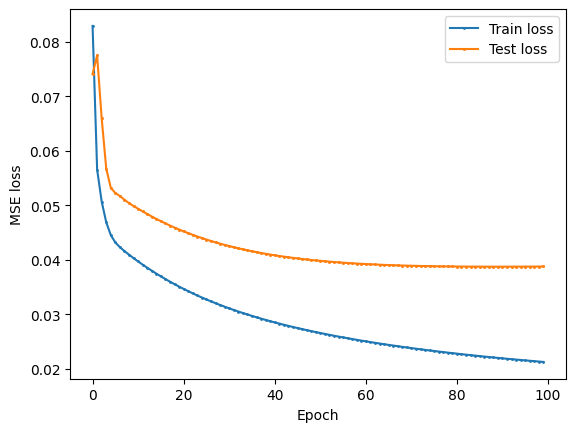

In [70]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

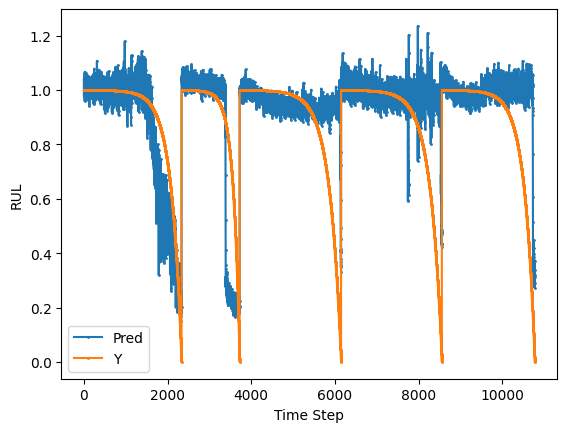

In [71]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

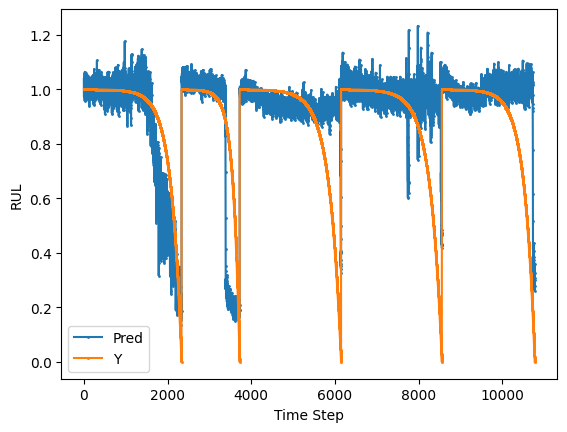

In [72]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [73]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")


0.0212457
0.0387332
0.1968074


In [ ]:
# run above

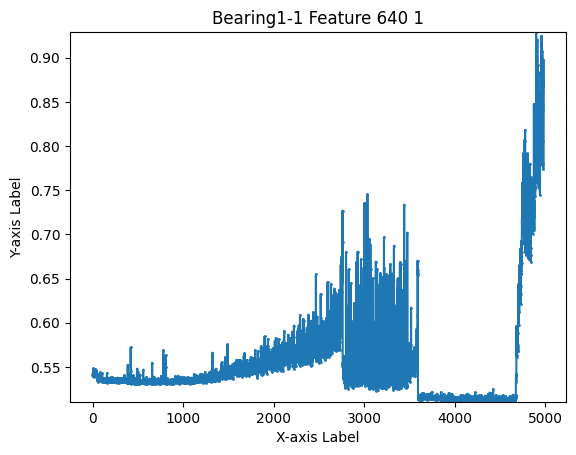

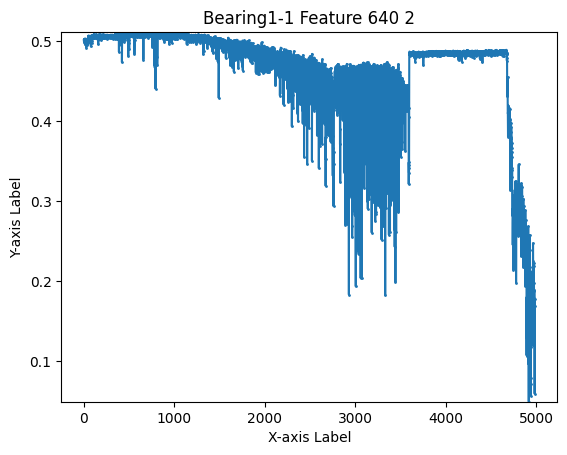

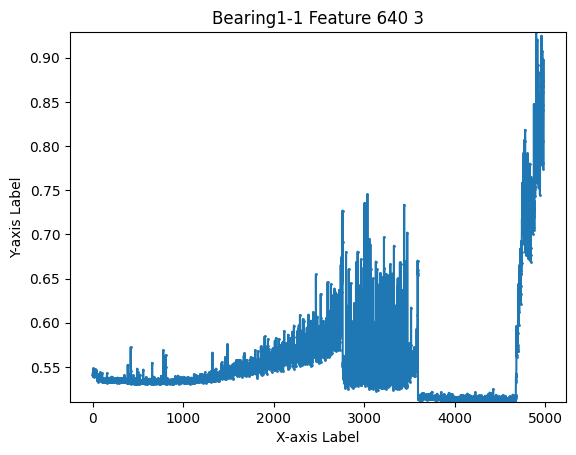

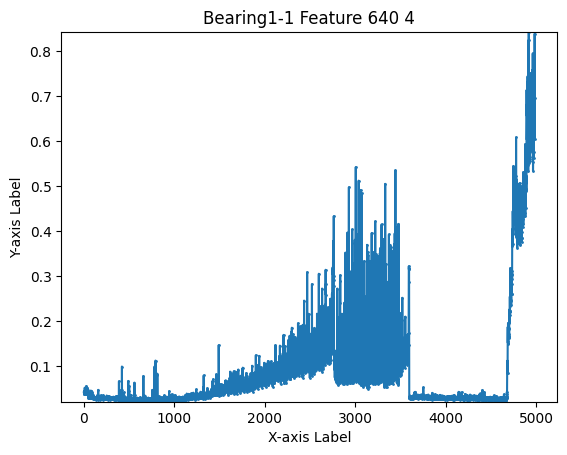

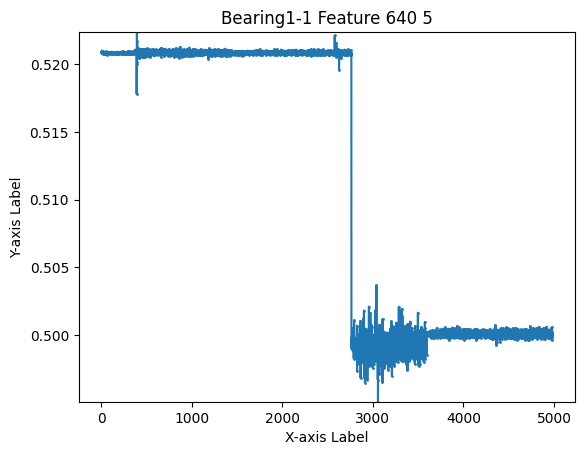

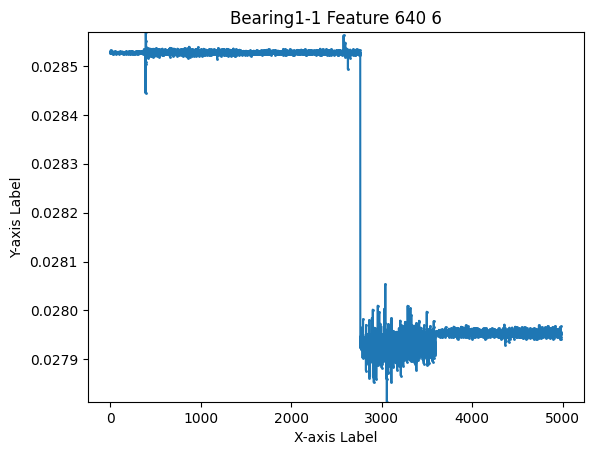

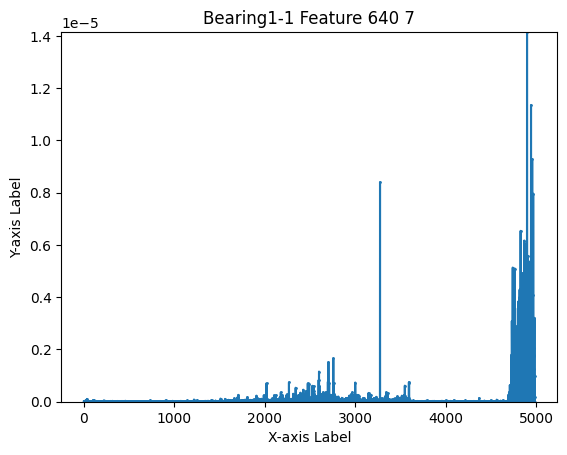

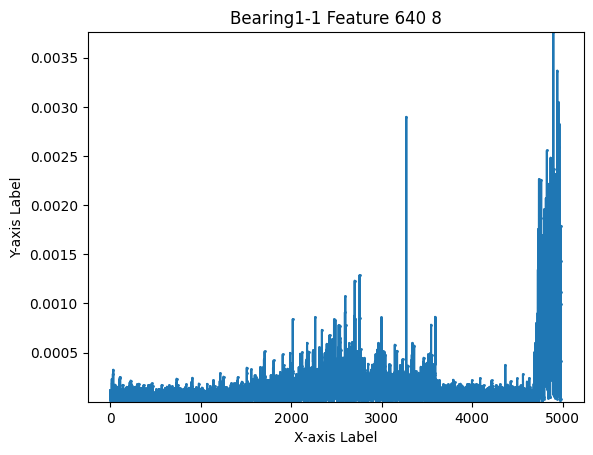

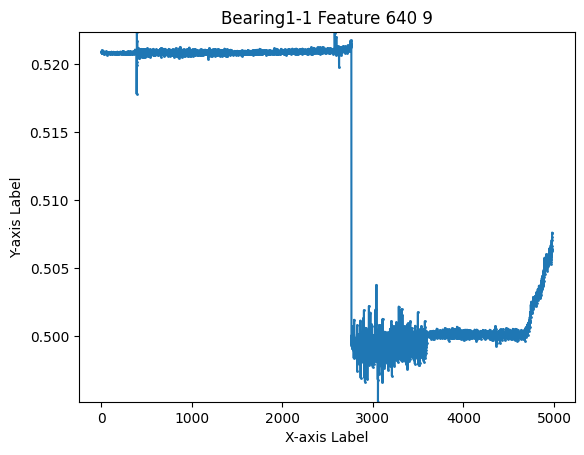

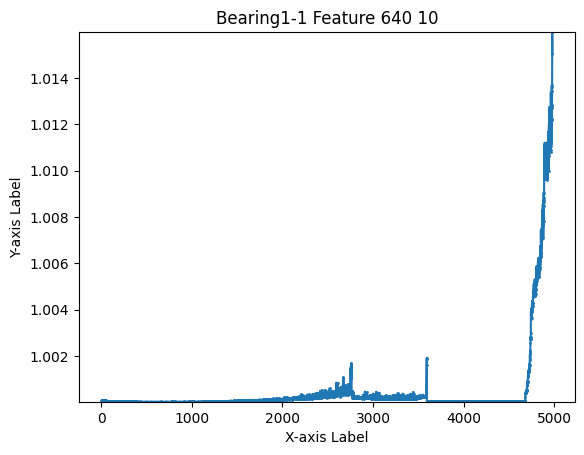

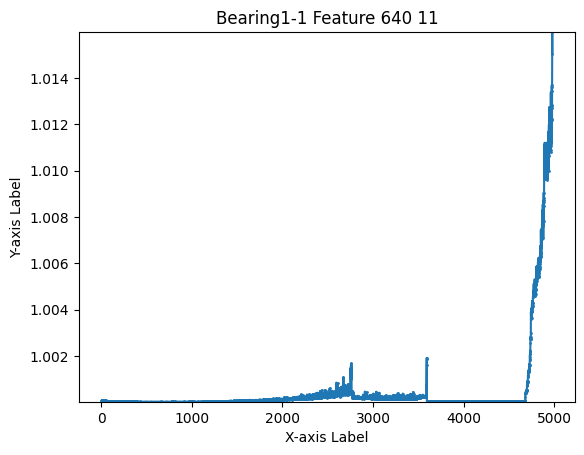

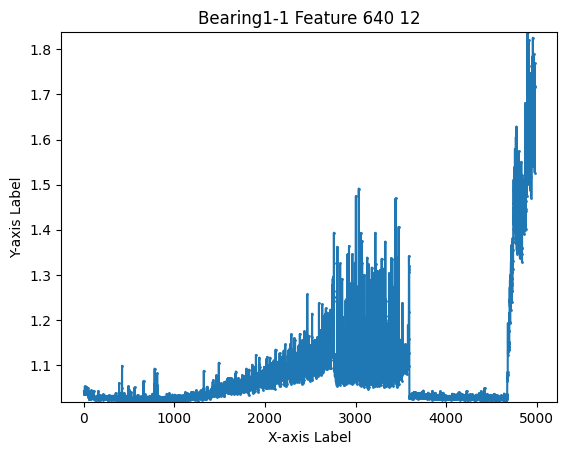

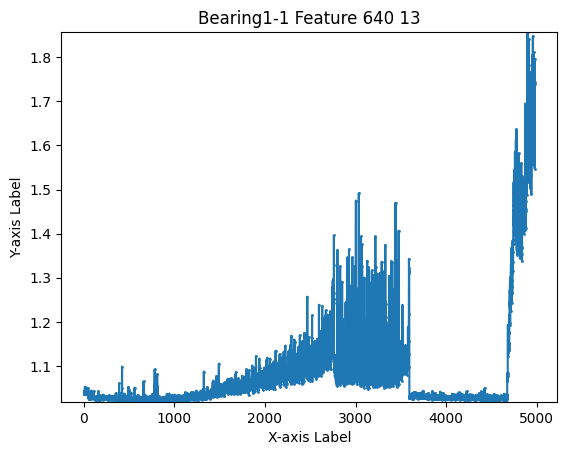

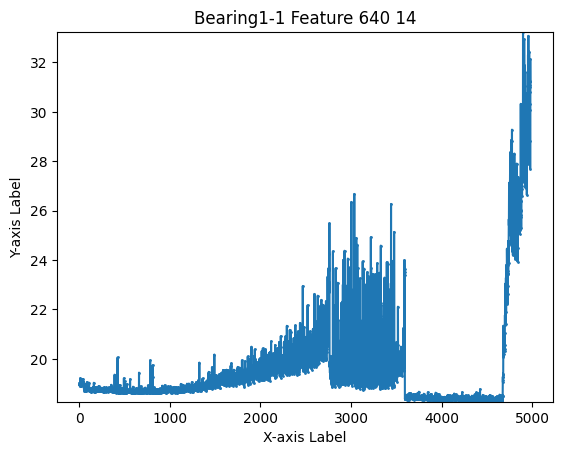

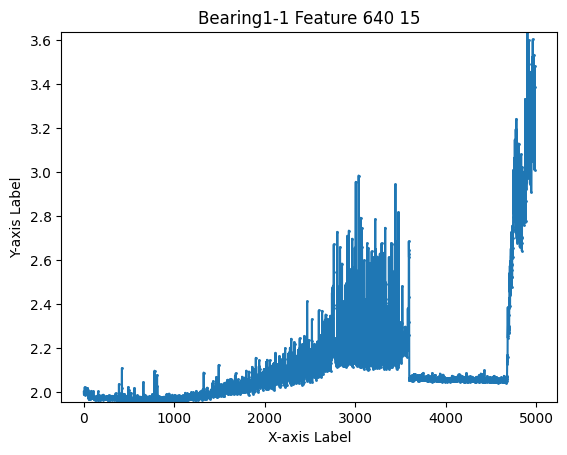

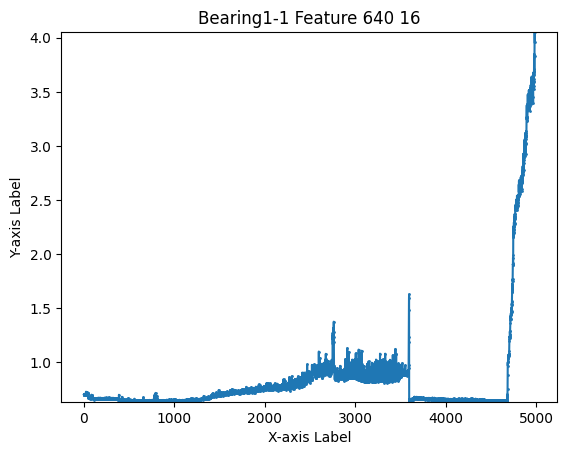

In [26]:
# draw three dataset all feature
x = dast_model.X_train
for i in range(16):
# Plotting the line chart
    plt.plot(x[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(x[:, 0, i]), max(x[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature 640 {i+1}')
    # Display the plot
    plt.show()

# RUN above

In [ ]:
import matplotlib.pyplot as plt
# Example data
X_draw = X_train[:2763, 0, 4]
# Plotting the line chart
plt.plot(X_draw, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing 1-1 Horizontal Vibration Signal')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.plot(X_train_1[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_1[:, 0, i]), max(X_train_1[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature {i+1}')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_2[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_2[:, 0, i]), max(X_train_2[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-2 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_3[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_3[:, 0, i]), max(X_train_3[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-4 Feature {i+1}')
    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_test[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_test[:, 0, i]), max(X_test[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-3 Feature {i+1}')
    # Display the plot
    plt.show()